In [1]:
import datetime as dt
import os
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Load DataSet

In [2]:
train_df = pd.read_csv("../input/zhibindata.csv", nrows = 9750645)
train_df.dtypes

Unnamed: 0              int64
key                    object
fare_amount           float64
pickup_datetime        object
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count         int64
abs_diff_longitude    float64
abs_diff_latitude     float64
dtype: object

Data Exploration

In [3]:
print(train_df.isnull().sum())

Unnamed: 0            0
key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count       0
abs_diff_longitude    0
abs_diff_latitude     0
dtype: int64


In [4]:
import matplotlib.pyplot as plt

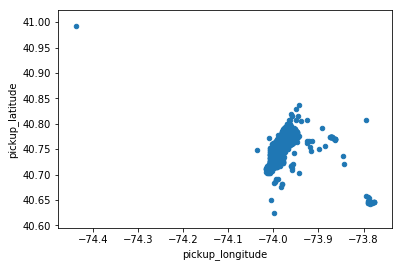

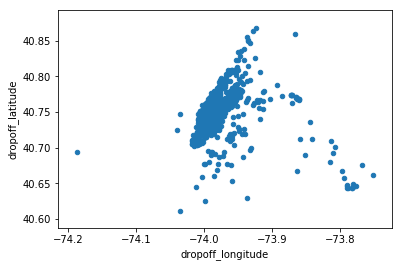

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
count,9.750645e+06,9.750645e+06,9.750645e+06,9.750645e+06,9.750645e+06,9.750645e+06,9.750645e+06,9.750645e+06,9.750645e+06
mean,4.999705e+06,1.132601e+01,-7.397515e+01,4.075110e+01,-7.397430e+01,4.075146e+01,1.690576e+00,2.278195e-02,2.131668e-02
std,2.886771e+06,9.681748e+00,3.840572e-02,2.950159e-02,3.754662e-02,3.272592e-02,1.306262e+00,3.514707e-02,2.413102e-02
min,0.000000e+00,0.000000e+00,-7.449954e+01,4.050005e+01,-7.449991e+01,4.050003e+01,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.499544e+06,6.000000e+00,-7.399228e+01,4.073656e+01,-7.399158e+01,4.073560e+01,1.000000e+00,6.125000e-03,6.930000e-03
50%,4.999803e+06,8.500000e+00,-7.398210e+01,4.075336e+01,-7.398061e+01,4.075387e+01,1.000000e+00,1.268300e-02,1.415800e-02
75%,7.499597e+06,1.250000e+01,-7.396832e+01,4.076755e+01,-7.396536e+01,4.076840e+01,2.000000e+00,2.390900e-02,2.719000e-02
max,9.999999e+06,9.520000e+02,-7.280843e+01,4.175844e+01,-7.280626e+01,4.173163e+01,6.000000e+00,1.232190e+00,9.932630e-01


In [ ]:
# Plot variables using only 1000 rows for efficiency
train_df.iloc[:1000].plot.scatter('pickup_longitude', 'pickup_latitude')
train_df.iloc[:1000].plot.scatter('dropoff_longitude', 'dropoff_latitude')
plt.show()
# Get distribution of values
train_df.describe()

Feature engineering
Add some interesting features in the dataset:

total_distance: distance from pickup to dropoff. The longer the trip, the more expensive.
Extract information from datetime( day of week, month, hour, day). Taxi fares change day/ night or on weekdays/ holidays.

In [ ]:
def sphere_dist(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates
    """
    # Define earth radius (km)
    R_earth = 6371
    # Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians, 
                                                           [pickup_lat, pickup_lon, 
                                                            dropoff_lat, dropoff_lon])
    # Compute distance along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    # Compute haversine distance
    a = np.sin(dlat / 2.0) ** 2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon / 2.0) ** 2
    return 2 * R_earth * np.arcsin(np.sqrt(a))
    

def add_datetime_info(dataset):
    #Convert to datetime format
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
    
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['weekday'] = dataset.pickup_datetime.dt.weekday
    dataset['year'] = dataset.pickup_datetime.dt.year
    
    return dataset

In [ ]:
train_df = add_datetime_info(train_df)
train_df['distance'] = sphere_dist(train_df['pickup_latitude'], train_df['pickup_longitude'], 
                                   train_df['dropoff_latitude'] , train_df['dropoff_longitude'])

train_df.head() 

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,hour,day,month,weekday,year,distance
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,17,15,6,0,2009,1.030764
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,16,5,1,1,2010,8.450134
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,0,18,8,3,2011,1.389525
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,4,21,4,5,2012,2.799270
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,7,9,3,1,2010,1.999157


In [ ]:
train_df.drop(columns=['Unnamed: 0', 'key', 'pickup_datetime'], inplace=True)
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,hour,day,month,weekday,year,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,17,15,6,0,2009,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,16,5,1,1,2010,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,0,18,8,3,2011,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,4,21,4,5,2012,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,7,9,3,1,2010,1.999157


Model training
Now that we have the dataframe that we wanted we can start to train the XGBoost model. First we will split the dataset into train(99%) and test(1%). With this amount of data 1% should be enough to test performance.

In [ ]:
y = train_df['fare_amount']
train = train_df.drop(columns=['fare_amount'])

x_train, x_test, y_train, y_test = train_test_split(train, y, random_state=0, test_size=0.01)

In [ ]:
%%time
XGB_model = XGBRegressor(learning_rate=0.3, max_depth=6, n_jobs=-1, silent=False)
XGB_model.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Save the model!

In [ ]:
XGB_model.save_model('with_abs_coordinate_model.model')

In [ ]:
%%time
y_XGB_predict = XGB_model.predict(x_test)

XGB_model_error = np.sqrt(mean_squared_error(y_test, y_XGB_predict))

print(f'XGBoost Root Mean Squared Error - {XGB_model_error}')

Prediction

Finally we can use our trained model to predict the submission. First we will need to load and preprocess the test dataset just like we did for the training dataset.

In [ ]:
# Read and preprocess test set
test_df = pd.read_csv('../input/test.csv')
test_df = add_datetime_info(test_df)
test_df['distance'] = sphere_dist(test_df['pickup_latitude'], test_df['pickup_longitude'], 
                                   test_df['dropoff_latitude'] , test_df['dropoff_longitude'])

test_key = test_df['key']
x_pred = test_df.drop(columns=['key', 'pickup_datetime'])

#Predict from test set
prediction = XGB_model.predict(x_pred)

In [ ]:
#Create submission file
submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction.round(2)
})
submission = submission[['key', 'fare_amount']]
submission.to_csv('zhibindata_taxi_fare_submission.csv',index=False)
submission.head()